In [ ]:
library(rio)
library(tidyverse)
library(smwrData)
library(smwrBase)
library(smwrGraphs)
library(scales)
library(corrplot)
library(factoextra)

In [2]:
theme_glab = function(
    base_size=12,
    base_family="",
    base_line_size=base_size / 180,
    base_rect_size=base_size / 180
) {

    # Assign font family up front
    font = "Helvetica"

    ggplot2::theme_bw(
        base_size=base_size, 
        base_family=base_family,
        base_line_size=base_line_size
    ) %+replace%
    ggplot2::theme(
        legend.background=element_blank(),
        legend.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65),
            hjust=0
        ),
        legend.text=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        legend.key.size=unit(0.8, "lines"),
        plot.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255), 
            hjust=0
        ),
        axis.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        axis.text=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        plot.caption=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.35),
            hjust=1
        ), 
        panel.grid.major=element_blank(),   
        panel.grid.minor=element_blank(),   
        panel.border=element_rect(
            colour=rgb(100, 100, 100, maxColorValue=255),
            fill=NA
        ),
        complete=TRUE
    )
}

In [ ]:
# Load all helper functions
loaded_scripts = sapply(list.files("../R/", full.names=TRUE), source)

In [4]:
PROJECT_NAME = "ARG23"

DATA_DIR = file.path(
    "../data/",
    PROJECT_NAME
)

## Decription of the input files

* **DIC data** - *ARG23.xlsx*

* **Alkalinity data** - *ARG23_dataset.xlsx*

* **IC data** - *ARG_23.csv*

* **ICP-MS data** - *ARG23_dil1at10.xlsx*

## DIC analysis

In [5]:
dic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23.xlsx"
    ),
    skip=4
)

dic_df = dic_df %>%
    # Drop NA rows
    drop_na(Name) %>%
    # Format "Sample Type"
    mutate(`Sample Type`=str_replace_all(
            string=`Sample Type`,
            pattern="\\(|\\)",
            replacement=""
        )
    ) %>%
    # Convert to numeric
    mutate(
        `Height (nA)`=as.numeric(`Height (nA)`),
        `δ¹³C (Gas)`=as.numeric(`δ¹³C (Gas)`)
    ) %>%
    # Group by name and calculate the mean
    group_by(Name) %>%
    summarise(
        Height_mean=mean(`Height (nA)`),
        DeltaC13_mean=mean(`δ¹³C (Gas)`),
        DeltaC13_sd=sd(`δ¹³C (Gas)`) # TODO: check use of SE
    )

dic_df = dic_df %>%
    # Natural sort by name
    slice(stringr::str_order(dic_df$Name, numeric=TRUE)) %>%
    # Transform to factor for plotting the samples in the correct order
    mutate(Name=factor(Name, levels=Name))

dic_df

Name,Height_mean,DeltaC13_mean,DeltaC13_sd
<fct>,<dbl>,<dbl>,<dbl>
ARG23_1,6.4190218,-3.4409935,0.1359016
ARG23_2,4.0301275,-5.5271253,0.2716068
ARG23_3,5.4543274,-3.1768285,0.8068695
ARG23_4,3.5758961,-9.9798606,0.4742499
ARG23_5,1.8756161,-5.9922322,0.7973183
ARG23_6,12.8719853,-2.6227354,0.5387774
ARG23_7,1.4093049,-6.6174893,0.7180623
ARG23_8,4.7544556,-5.8113600,0.2032612
ARG23_9,2.6648682,-4.2482822,0.1525767


In [6]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-dic.png")
    ),
    width=7,
    height=7
)

figure_dic = ggplot(
        data=dic_df,
        aes(
            x=Name,
            y=DeltaC13_mean,
            fill=Name
        )
    ) +
    geom_col() +
    geom_errorbar(
        aes(
            ymin=DeltaC13_mean - DeltaC13_sd,
            ymax=DeltaC13_mean + DeltaC13_sd
        ),
        width=.2
    ) +
    theme_glab() +
    # Rotate X axis labels
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-dic.png"


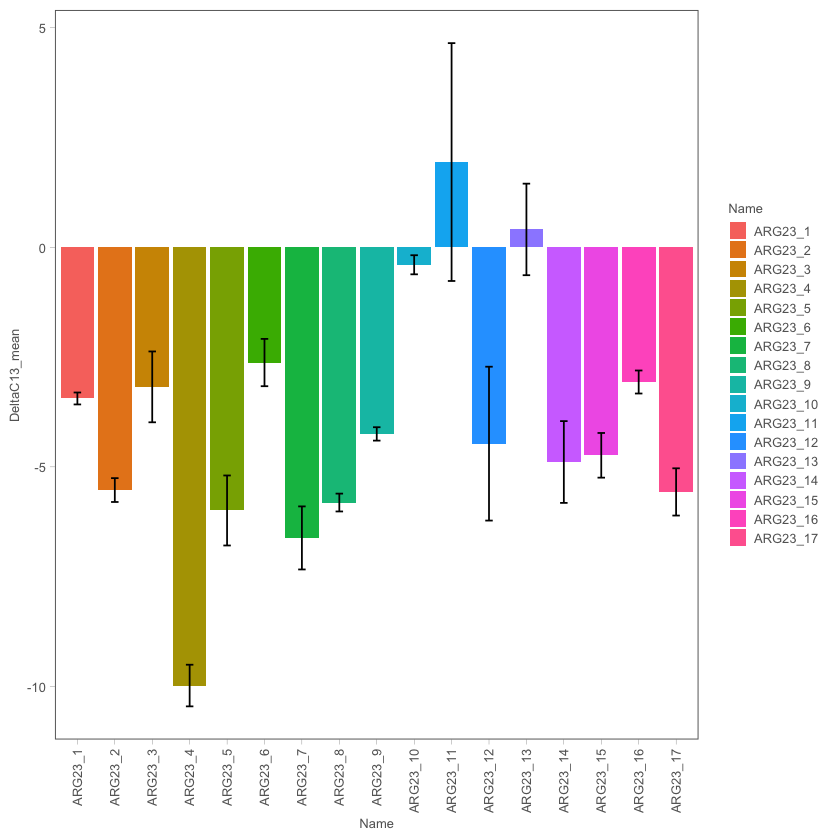

In [7]:
figure_dic

## IC analysis

In [8]:
sample_ids = c(
    "BF",
    "CM",
    "CZ",
    "ES",
    "JB",
    "LB",
    "LF",
    "LN",
    "LV",
    "OY",
    "OZ",
    "PI",
    "PQ",
    "QH",
    "RC1",
    "TZ",
    "VA"
)

In [9]:
ic_df = import(
    file=file.path(
        DATA_DIR,
        "ARG_23.csv"
    )
)
ic_df = process_ic_data(ic_df)

# Select samples
ic_df = ic_df %>% filter(ID %in% sample_ids)
ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,Ammonium,Potassium,Magnesium,Calcium
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BF,NA,1.00,1.870,NA,NA,2.216,NA,18.806,27.603,0.028,3.461,4.520,33.153
CM,NA,1.00,183.920,NA,0.213,NA,NA,353.485,NA,310.184,1.672,0.099,15.612
CZ,NA,9.98,89.249,NA,NA,NA,NA,26.656,175.147,0.472,3.440,3.820,23.274
ES,NA,49.94,3805.285,NA,NA,NA,NA,1920.534,3413.427,2.503,51.482,23.053,147.261
JB,NA,9.96,134.659,NA,NA,NA,NA,192.232,167.601,0.607,19.613,18.879,66.266
LB,NA,98.96,8426.104,NA,NA,10581.428,NA,1139.520,5489.607,14.688,18.095,71.350,341.678
LF,NA,96.63,2325.151,NA,NA,NA,NA,NA,1701.202,13.009,47.645,31.021,145.921
LN,NA,10.09,83.306,NA,NA,6.532,NA,48.850,407.591,0.219,15.718,3.493,40.969
LV,NA,175.27,22700.545,NA,22.374,NA,NA,1947.880,10966.267,10.495,736.896,821.218,1003.251


In [10]:
# Add bicarbonate data
bicarb_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dataset.xlsx"
    ),
    sheet="env_data"
)
bicarb_df = bicarb_df %>%
    select(ID, hco3) %>%
    rename(Bicarbonate=hco3)

ic_df = left_join(
    x=ic_df,
    y=bicarb_df,
    by="ID"
)

# Calculate meq for plotting
ic_df = ic_df %>%
    # WARNING: concentrations must be in mg/L!!!
    mutate(
        HCO3.meq=conc2meq(Bicarbonate, "bicarb"),
        Cl.meq=conc2meq(Chloride, "chloride"),
        SO4.meq=conc2meq(Sulfate, "sulfate"),
        Na.meq=conc2meq(Sodium, "sodium"),
        K.meq=conc2meq(Potassium, "potassium"),
        Ca.meq=conc2meq(Calcium, "calcium"),
        Mg.meq=conc2meq(Magnesium, "magnesium")
    )

# Calculate ion balance
ic_df = ic_df %>%
    mutate(
        sum_anions=(HCO3.meq + Cl.meq + SO4.meq),
        sum_cations=(Na.meq + K.meq + Ca.meq + Mg.meq)
    ) %>%
    mutate(
        IB=100 * (sum_cations - sum_anions) / (sum_cations + sum_anions)
    )

ic_df

ID,Expedition,Dilution,Chloride,Nitrite,Bromide,Nitrate,Phosphate,Sulfate,Sodium,⋯,HCO3.meq,Cl.meq,SO4.meq,Na.meq,K.meq,Ca.meq,Mg.meq,sum_anions,sum_cations,IB
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BF,NA,1.00,1.870,NA,NA,2.216,NA,18.806,27.603,⋯,2.6994330,0.0527527,0.3915409,1.2007305,0.08853238,1.6543347,0.37195080,3.143727,3.315548,2.6600781
CM,NA,1.00,183.920,NA,0.213,NA,NA,353.485,NA,⋯,2.0395716,5.1883832,7.3595577,NA,0.04276976,0.7790388,0.00814671,14.587512,NA,NA
CZ,NA,9.98,89.249,NA,NA,NA,NA,26.656,175.147,⋯,6.2386896,2.5177143,0.5549779,7.6188945,0.08799520,1.1613726,0.31434780,9.311382,9.182610,-0.6962894
ES,NA,49.94,3805.285,NA,NA,NA,NA,1920.534,3413.427,⋯,15.2967870,107.3470898,39.9855179,148.4840745,1.31690956,7.3483239,1.89703137,162.629395,159.046339,-1.1138718
JB,NA,9.96,134.659,NA,NA,NA,NA,192.232,167.601,⋯,4.9189668,3.7987304,4.0022702,7.2906435,0.50170054,3.3066734,1.55355291,12.719967,12.652570,-0.2656300
LB,NA,98.96,8426.104,NA,NA,10581.428,NA,1139.520,5489.607,⋯,16.4965350,237.7003938,23.7248064,238.7979045,0.46287010,17.0497322,5.87139150,277.921735,262.181898,-2.9142253
LF,NA,96.63,2325.151,NA,NA,NA,NA,NA,1701.202,⋯,18.5960940,65.5925097,NA,74.0022870,1.21875910,7.2814579,2.55271809,NA,85.055222,NA
LN,NA,10.09,83.306,NA,NA,6.532,NA,48.850,407.591,⋯,16.7964720,2.3500623,1.0170570,17.7302085,0.40206644,2.0443531,0.28743897,20.163591,20.464067,0.7395842
LV,NA,175.27,22700.545,NA,22.374,NA,NA,1947.880,10966.267,⋯,13.2572154,640.3823744,40.5548616,477.0326145,18.84979968,50.0622249,67.57802922,694.194451,613.522668,-6.1689017


#### Giggenbach diagram

In [11]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-giggenbach-cations-plot.png")
    ),
    width=7,
    height=7
)

figure_gigg_cations = plot_base_gigg_cations() +
    geom_point(
        data=ic_df,
        aes(
            x=K.meq/100,
            y=Na.meq/1000,
            z=sqrt(Mg.meq),
            fill=ID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-giggenbach-cations-plot.png"


Warning message in geom_point(data = ic_df, aes(x = K.meq/100, y = Na.meq/1000, :
“Ignoring unknown aesthetics: z”


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


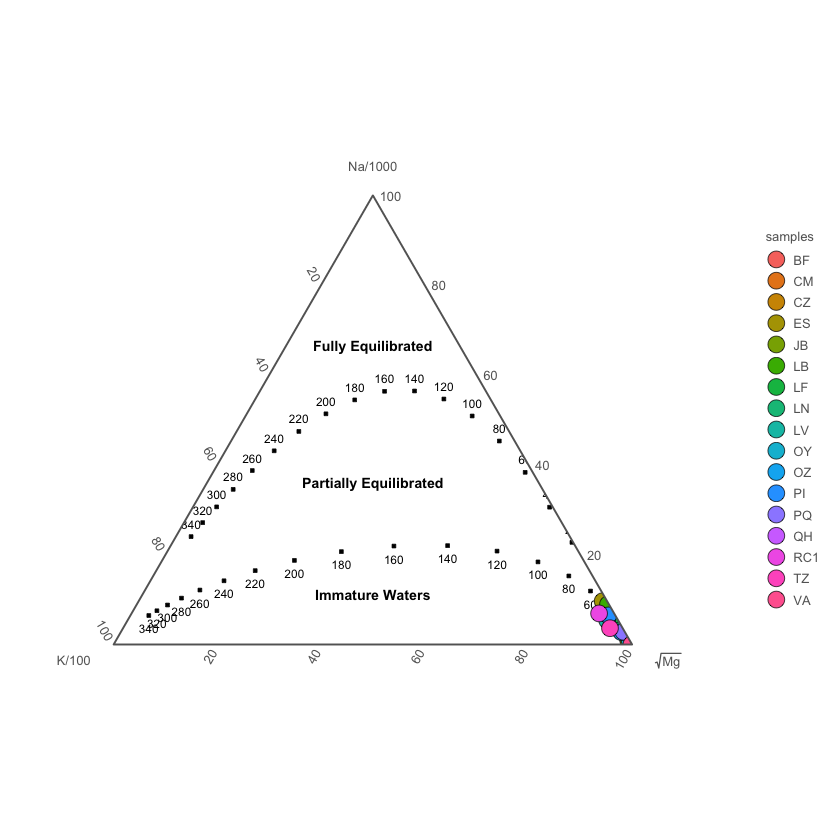

In [12]:
figure_gigg_cations

In [13]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-giggenbach-anions-plot.png")
    ),
    width=7,
    height=7
)

figure_gigg_anions = plot_base_gigg_anions() +
    geom_point(
        data=ic_df,
        aes(
            x=SO4.meq,
            y=Cl.meq,
            z=HCO3.meq,
            fill=ID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-giggenbach-anions-plot.png"


Warning message in geom_segment(data = lines, aes(x = x, y = y, z = z, xend = xend, :
“Ignoring unknown aesthetics: z and zend”
Warning message in geom_polygon(data = polygon, aes(x = x, y = y, z = z), color = "black", :
“Ignoring unknown aesthetics: z”
Warning message in geom_point(data = ic_df, aes(x = SO4.meq, y = Cl.meq, z = HCO3.meq, :
“Ignoring unknown aesthetics: z”


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


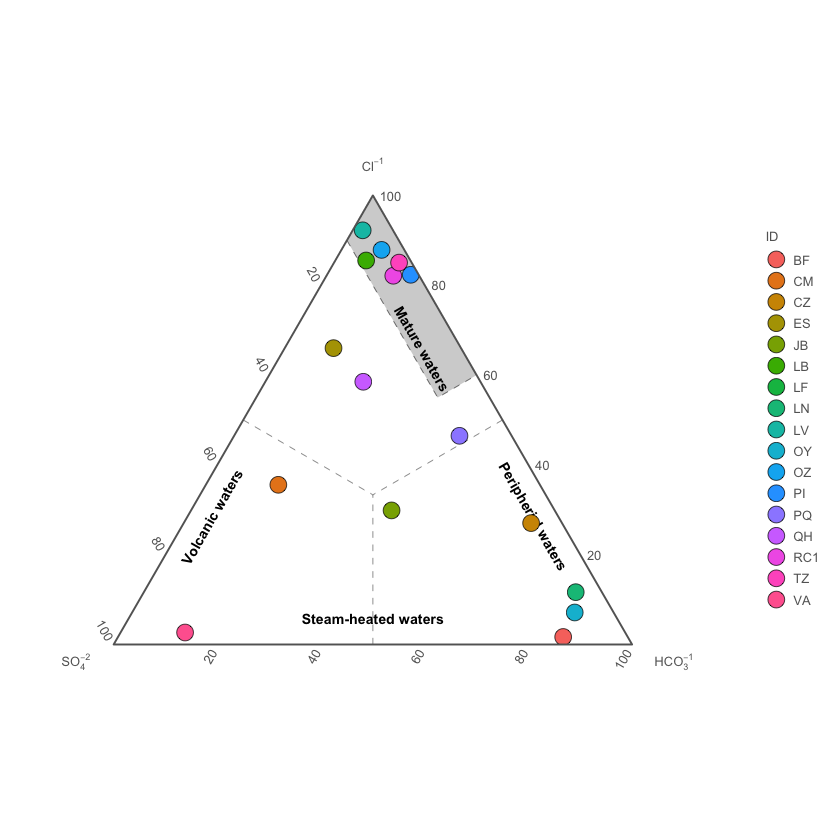

In [14]:
figure_gigg_anions

#### Langelier-Ludwig diagram

In [15]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-langelier-ludwig-plot.png")
    ),
    width=7,
    height=7
)

figure_ll = plot_ll(ic_df) +
    theme_glab()

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-langelier-ludwig-plot.png"


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


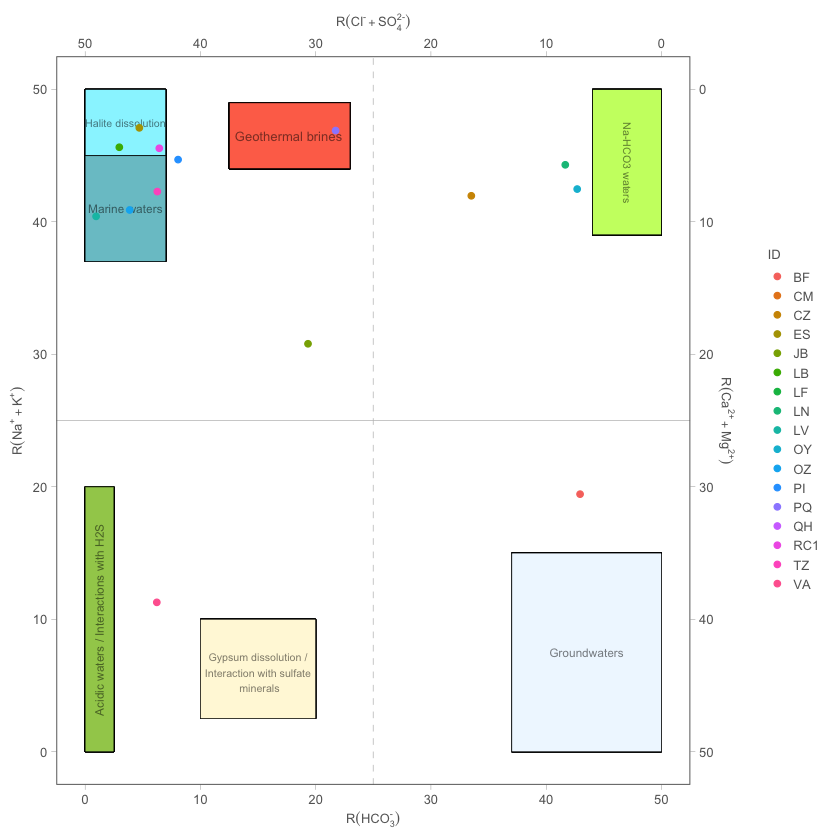

In [16]:
figure_ll

#### Piper diagram

In [17]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-piper-plot.png")
    ),
    width=7,
    height=7
)

figure_piper = smwrGraphs::piperPlot(
        xCat=ic_df$Ca.meq,
        yCat=ic_df$Mg.meq,
        zCat=ic_df$Na.meq,
        xAn=ic_df$Cl.meq,
        yAn=ic_df$HCO3.meq,
        zAn=ic_df$SO4.meq,
        Plot=list(
            name=ic_df$ID,
            color=setColor(hue_pal()(length(unique(ic_df$ID))))
        ),
        zCat.title="Sodium",
        xAn.title="Chloride",
        yAn.title="Bicarbonate"
    ) %>%
    addExplanation(
        where="ul",
        title="Piper diagram"
    )

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-piper-plot.png"


## ICP-MS analysis

In [ ]:
icp_df = process_icp_data(
    file.path(
        DATA_DIR,
        "ARG23_dil1at10.xlsx"
    )
)

Warning message:
“Removed 18 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 18 rows containing missing values (`position_stack()`).”


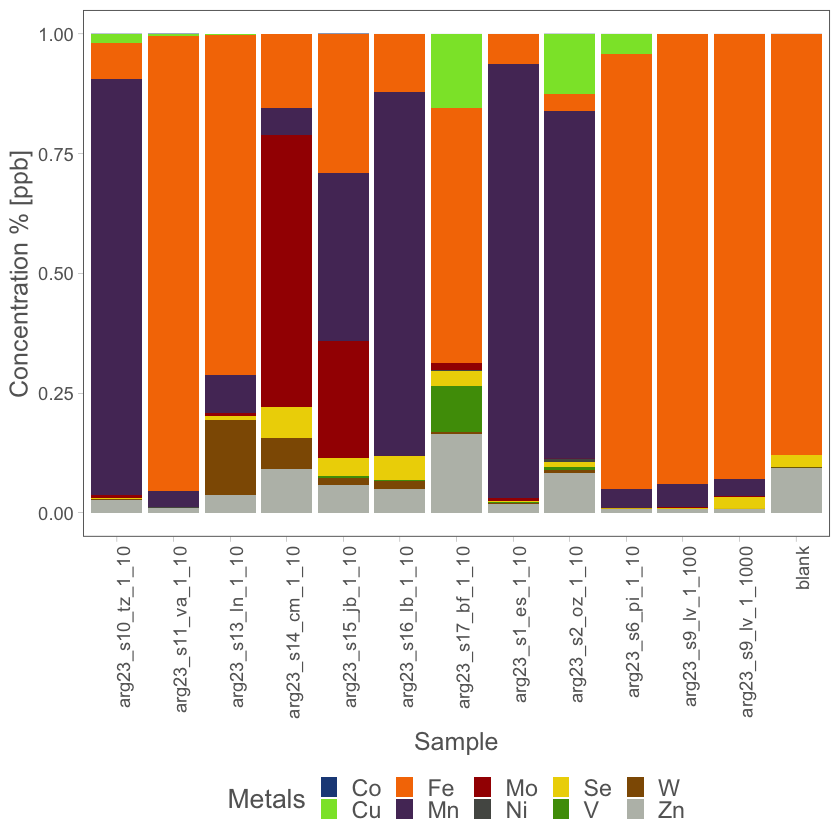

In [68]:
selected_metals = read.csv(
        text="element,color
            Fe,#f57900
            V,#4e9a06
            Mn,#563566
            Co,#204a87
            Ni,#555753
            Cu,#8ae234
            Zn,#babdb6
            Se,#edd400
            Mo,#a40000
            W,#8f5902"
    ) %>%
    # Replace indentation whitespaces
    mutate(
        element=str_replace(
            string=element,
            pattern="\\s+",
            replacement=""
        )
    )

# Create a named vector
selected_metals = selected_metals %>% deframe()

figure_metals = ggplot(
        data=icp_df %>% filter(element %in% names(selected_metals)),
        aes(fill=element, y=concentration, x=sample)
    ) +
    geom_bar(position="fill", stat="identity") +
    theme_glab() +
    theme(
        axis.text=element_text(size=11),
        axis.text.x=element_text(angle=90, hjust=1),
        # axis.ticks.x=element_line(vjust=5),
        strip.text.x=element_text(size=20),
        legend.position="bottom", 
        legend.text=element_text(size=14),
        legend.title=element_text(size=16),
        panel.grid.minor=element_blank(), 
        panel.grid.major=element_blank(),
        panel.background=element_blank(),
        axis.title=element_text(
            size=15,
            color=rgb(100, 100, 100, maxColorValue = 255)
        ),
        axis.title.x=element_text(vjust=-0.5)
    ) +
    xlab("Sample") +
    ylab("Concentration % [ppb]") +
    scale_colour_manual(
        name="Metals",
        values=selected_metals,
        aesthetics="fill"
    )

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-metals.png")
    ),
    width=7,
    height=7
)

figure_metals

## Correlation and dimensionality reduction

In [21]:
env_data_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dataset.xlsx"
    ),
    sheet="env_data"
)

env_data_df

,ID,series,CollectionID,Country,SiteName,year,date,rock_type,lithology_unit,latitude,⋯,h2s,fe2+,avg_v,avg_mn,avg_fe,avg_co,avg_ni,avg_cu,avg_mo,avg_w
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ES,1,ES230304,Argentina,El Sauce,2023,45019.0,siliciclastic,Qs1,-24.59445,⋯,0.03,0.026,0.4710,427.6570,25.7390,NA,15.1110,1.4500,4.2105,1.3490
2,OZ,2,OZ230305,Argentina,Olaruz,2023,45049.0,evaporitic,Nw,-23.34416,⋯,1.00,0.012,3.1810,371.6800,5.2830,NA,NA,64.8850,0.4770,4.2855
3,RC1,3,RC1230306,Argentina,Rosario de Coyaguima,2023,45080.0,siliciclastic,Es1,-22.87706,⋯,2.00,1.285,NA,67.5110,430.5875,0.1220,NA,76.9100,2.5365,NA
4,PQ,4,PQ230306,Argentina,Pairique,2023,45080.0,siliciclastic,Es1,-22.90280,⋯,6.00,0.309,NA,13.6125,182.0775,NA,NA,NA,5.1660,4.1065
5,CZ,5,CZ230307,Argentina,Coranzuli,2023,45110.0,siliciclastic,Os1,-22.97502,⋯,6.00,0.11,NA,26.7510,111.2545,NA,NA,NA,4.7485,9.3825
6,PI,6,PI230308,Argentina,Pirquitas,2023,45141.0,siliciclastic,Ns1,-22.73454,⋯,4.00,4.85,0.7165,213.8895,5201.6040,1.0405,3.2400,230.8365,1.5450,3.7245
7,OY,7,OY230308,Argentina,Orosmayo,2023,45141.0,siliciclastic,Ns1,-22.53242,⋯,2.00,0.014,NA,11.1315,73.7735,0.0490,NA,0.8680,4.7250,4.6835
8,LF,8,LF230308,Argentina,Lagunilla del Farallon,2023,45141.0,siliciclastic,Ns1,-22.41294,⋯,NA,0.354,NA,62.5810,361.4040,NA,0.3970,1.2120,NA,27.3570
9,LV,9,LV230309,Argentina,Laguna de Vilama,2023,45172.0,siliciclastic,Qs1,-22.60727,⋯,4.00,4.61,1.6040,922.2825,19630.7550,NA,NA,NA,3.8495,4.9375


In [22]:
features_df = env_data_df %>%
    # Get features
    select(10:ncol(env_data_df)) %>%
    # Replace below detection limit values
    mutate(across(everything(), ~as.numeric(.x))) %>%
    # Fill NA with zeroes
    mutate(across(everything(), ~replace_na(.x, 0)))

# Get the correlation matrix
corr_matrix = cor(as.matrix(features_df))

corr_matrix

Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `across(everything(), ~as.numeric(.x))`.
Caused by warning:
! NAs introducidos por coerción
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


,latitude,longitude,altitude,temp,ph,orp,do,do_ppm,spc,tds,⋯,h2s,fe2+,avg_v,avg_mn,avg_fe,avg_co,avg_ni,avg_cu,avg_mo,avg_w
latitude,1.000000000,-0.041707872,0.49458996,0.023519944,-0.18877233,-0.2252368047,0.60142881,0.24072336,0.33918695,0.09394084,⋯,-0.10669339,0.34198990,-0.374596448,0.01423130,0.03531674,-0.10243406,-0.08891780,0.176744837,-0.29586999,-0.55295006
longitude,-0.041707872,1.000000000,-0.84803044,0.431572398,0.17287224,-0.0586227138,-0.24698568,0.39075102,-0.14019317,-0.17326404,⋯,0.05772913,-0.32712754,0.006403722,-0.19554954,-0.17140497,-0.04322027,0.34320015,-0.236644875,0.40318629,-0.24967948
altitude,0.494589963,-0.848030437,1.00000000,-0.390691664,-0.38994752,0.0334213509,0.43501673,-0.25148649,0.22379654,0.20710096,⋯,0.09214160,0.40553000,-0.066780801,0.33862320,0.30733289,0.18222197,-0.22145162,0.405043530,-0.51624299,-0.07996287
temp,0.023519944,0.431572398,-0.39069166,1.000000000,0.26173570,-0.1872165615,-0.02408239,-0.09581328,-0.06530890,0.42573426,⋯,-0.31038432,-0.25016637,-0.464923192,-0.05458293,-0.44749940,-0.37304910,-0.11843282,-0.415858856,0.49628194,0.02368467
ph,-0.188772332,0.172872243,-0.38994752,0.261735703,1.00000000,-0.2074774495,0.16097460,0.23848146,-0.34456927,-0.08414592,⋯,-0.68760126,-0.28874076,-0.286839083,-0.54253527,-0.72579385,-0.67787802,-0.30383276,-0.559340548,0.55726108,-0.01893244
orp,-0.225236805,-0.058622714,0.03342135,-0.187216562,-0.20747745,1.0000000000,0.16456821,0.22643472,-0.27420351,0.12781284,⋯,0.30639608,-0.04863066,0.565764091,0.44439582,0.38670088,0.45805355,0.43022403,0.315646143,0.41995745,-0.08697070
do,0.601428813,-0.246985685,0.43501673,-0.024082387,0.16097460,0.1645682101,1.00000000,0.63552618,0.04416378,0.23652203,⋯,-0.46170116,0.16352725,-0.087305629,0.11721898,-0.25700650,-0.34264359,-0.39353121,0.019826260,-0.11018132,-0.41549842
do_ppm,0.240723360,0.390751019,-0.25148649,-0.095813279,0.23848146,0.2264347227,0.63552618,1.00000000,-0.23010317,-0.07863282,⋯,-0.27468532,-0.13897249,0.217875496,-0.12605677,-0.25272472,-0.20841180,-0.09582503,-0.100049712,0.03348420,-0.32394477
spc,0.339186947,-0.140193168,0.22379654,-0.065308898,-0.34456927,-0.2742035122,0.04416378,-0.23010317,1.00000000,-0.18936338,⋯,-0.10560929,0.76037289,-0.207368847,0.19899111,0.26998258,-0.16713121,-0.20818131,0.108805816,-0.30506985,-0.16335936
tds,0.093940838,-0.173264045,0.20710096,0.425734262,-0.08414592,0.1278128391,0.23652203,-0.07863282,-0.18936338,1.00000000,⋯,-0.12828403,-0.19884814,-0.138297650,0.44558727,-0.17017322,-0.06874931,-0.08374397,-0.134302679,0.04192532,0.18530621


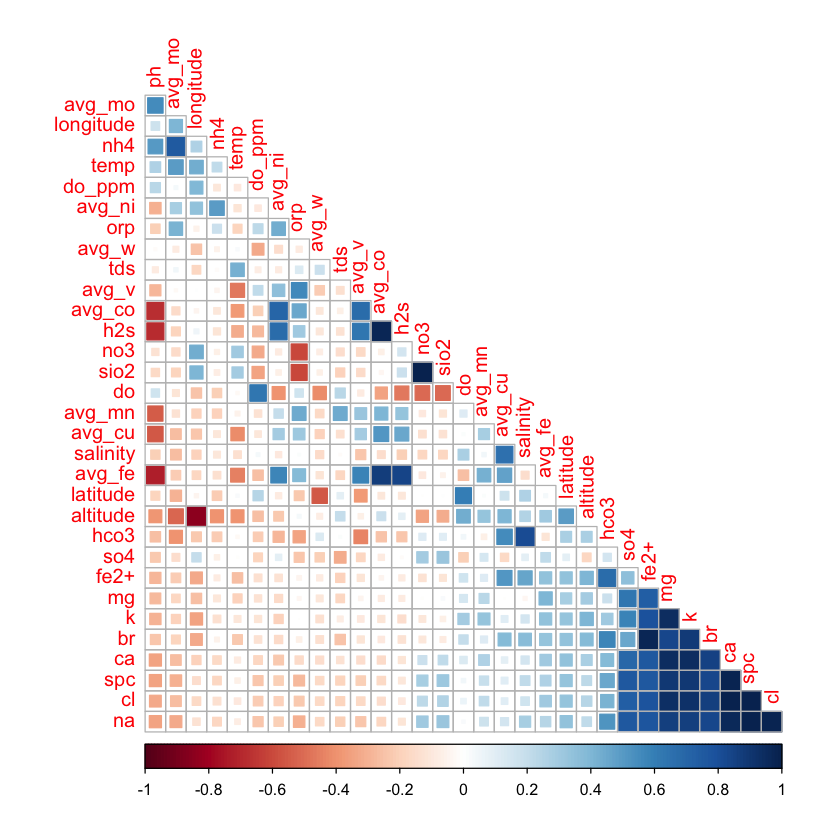

In [23]:
corrplot(
    corr_matrix,
    method="square",
    order="FPC",
    type="lower",
    insig="blank",
    diag=FALSE
)

In [24]:
pca_result = prcomp(features_df, scale = TRUE)

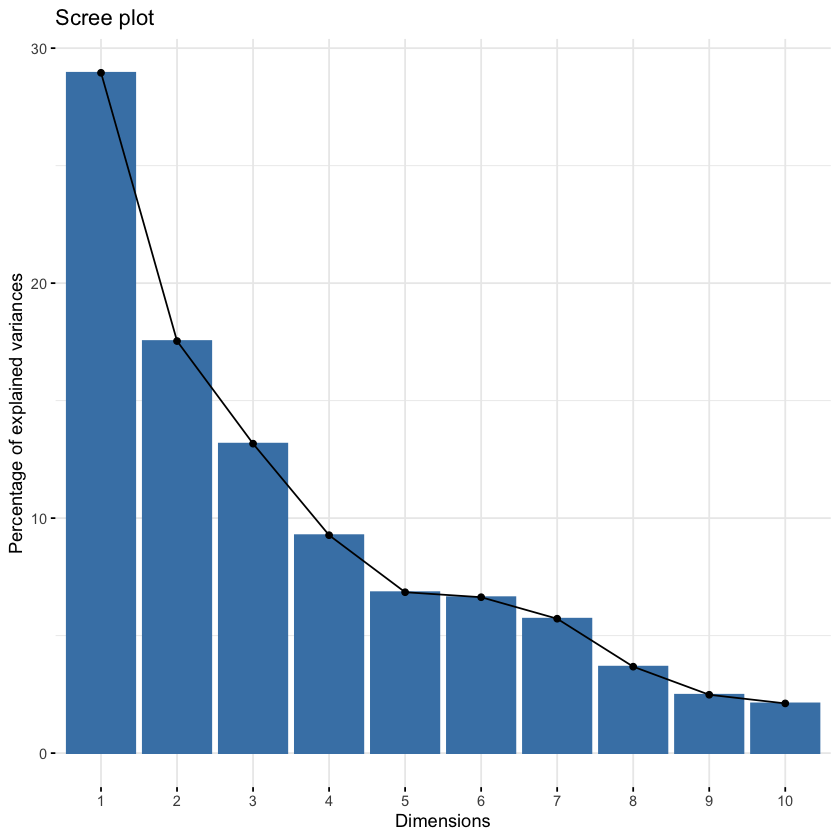

In [25]:
fviz_eig(pca_result)

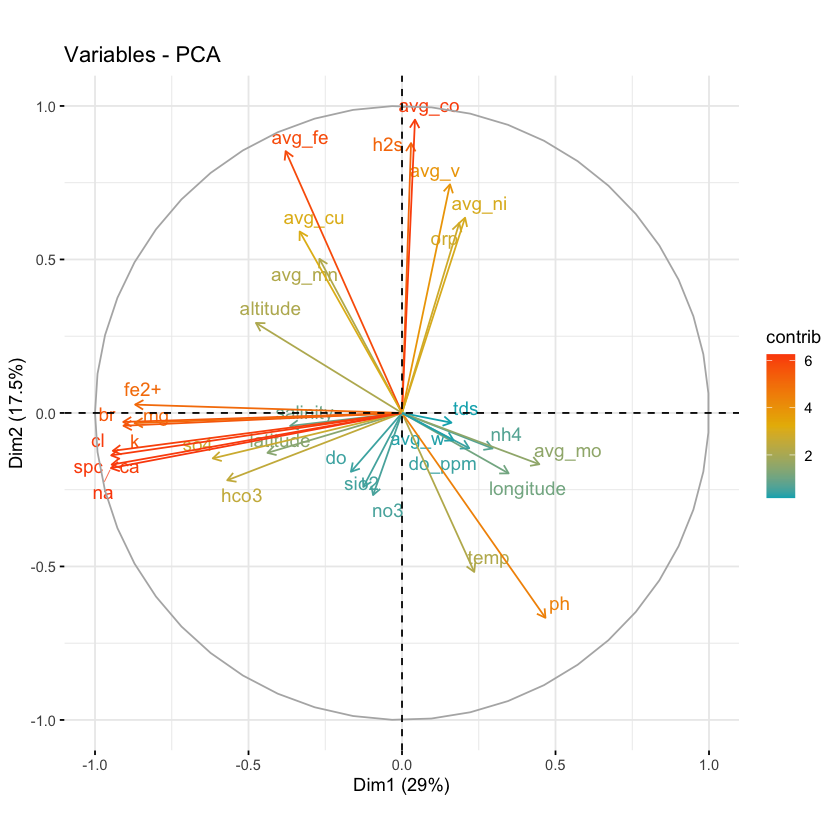

In [26]:
fviz_pca_var(
    pca_result,
    col.var="contrib", # Color by contributions to the PC
    gradient.cols=c("#00AFBB", "#E7B800", "#FC4E07"),
    repel=TRUE # Avoid text overlapping
)